In [1]:
# import SharedArray as sa
# ROBOT_TYPE_NAME = 'panda'
# sa.delete("shm://{}.prepared".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.grasp_img".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.arm_img".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.rh_vals".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.result".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.query_in".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.response_out".format(ROBOT_TYPE_NAME))
# sa.delete("shm://{}.query_quit".format(ROBOT_TYPE_NAME))

## Define printing function

In [410]:
from __future__ import print_function
import os
RNB_PLANNING_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(RNB_PLANNING_DIR, 'src'))
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir
from pkg.planning.pddlstream.convert_pscene import *
import subprocess

def print_results(RES_ROOT, RTYPE, DAT_DIR, CNAME_LIST=['None','Tool','ToolReach','Full'] #,'Pairwise']
                  , CNAMES_EXCLUDE=['None'], exp_list=['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard']
                  , read_only=False
                 ):
    DATA_PATH = os.path.join(RNB_PLANNING_DIR, "data")
    try_mkdir(DATA_PATH)

    # RES_ROOT = "stowing-result"
    # RES_ROOT = "stowing-deep-result-before-ik-only2"
    # RES_ROOT = "stowing-result-pddl-fin"

    TEST_RESULT_PATH = os.path.join(DATA_PATH, RES_ROOT)
    try_mkdir(TEST_RESULT_PATH)

    HEADS = np.array(["plan_time", "length", "MP_tot", "MP_count", "failed_MPs", "IK_tot", "IK_count", "failed_IKs", "success"])
    DISPS = np.array(["Time", "Actions", "MP_tot", "MP trials", "MP fails", "IK_tot", "IK trials", "IK fails", "Fail(%)", "Total"])
    H2D = {}
    D2H = {}
    for head, disp in zip(HEADS, DISPS):
        H2D[head] = disp
        D2H[disp] = head

    # DAT_DIR = '20210702-152658'
    # DAT_DIR = '20210707-034434'
    # DAT_DIR = '20210709-172009'
    # DAT_DIR = '20210820-162838'


    # RTYPE = "panda"
    # DAT_DIR = '20210705-182244'
    # FILE_OPTION = "obj_1"
    # # DAT_DIR, FILE_OPTION = "20210613-022832", "obj_1"
    # # # DAT_DIR, FILE_OPTION = "20210612-221934", "obj_1"

    GRASP_SAMPLE = 100
    VISUALIZE = True
    PLAY_RESULT = False
    SHOW_STATE = False

    TIMEOUT_MOTION = 5
    MAX_TIME = 100
    MAX_ITER = 100

    ROBOT_DATA_ROOT = os.path.join(TEST_RESULT_PATH, RTYPE)
    DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, DAT_DIR)
    file_list = sorted(os.listdir(DATASET_PATH))


    print("="*50)
    print("RES_ROOT: {}".format(RES_ROOT))
    print("DAT_DIR: {}".format(DAT_DIR))
    print("CNAME_LIST: {}".format(CNAME_LIST))
    print("="*50)

    resdat_all = defaultdict(lambda: defaultdict(list))
    res_dict_all = defaultdict(lambda: defaultdict(list))
    resfile_list = sorted(os.listdir(os.path.join(DATASET_PATH)))
    for resfile in resfile_list:
        if resfile.startswith("."):
            continue
        args = resfile[:-4].split("_")[1:]
        f_option = "_".join(args[:-2])
        fid, cname = args[-2:]
        resdat = load_pickle(os.path.join(DATASET_PATH, resfile))
        resdat_all[f_option][cname].append(resdat)
        res_dict_all[f_option][cname].append([resdat[head] if head in resdat else None for head in HEADS])
    if read_only:
        return resdat_all, res_dict_all
    
    for ekey in exp_list:
        print(ekey)
        if ekey not in res_dict_all:
            continue

        ## Check result file sanity
        fnames_dict = {}
        imax_min = None
        for cname in CNAME_LIST:
            fnames_dict[cname] = [int(fname.split("_")[-2]) for fname in resfile_list 
                                  if (ekey == "_".join(fname.split("_")[1:-2])
                                      and cname == fname.split("_")[-1].split(".")[0])]
            len_fnames = len(fnames_dict[cname])
            if len_fnames > 0:
                imax =max(fnames_dict[cname])
                imax_min = min([imax, imax_min]) if imax_min is not None else imax
                print("{} files: {}".format(cname, len_fnames))

        ## Print missing file if any
        missing_any = False
        for cname in CNAME_LIST:
            if len(fnames_dict[cname]) > 0:
                idc_missing = set(np.arange(imax_min+1))-set(fnames_dict[cname])
                if len(idc_missing) > 0:
                    missing_any = True
                    print("{} missing {}".format(cname, idc_missing))

        if missing_any:
            print("Skip as there's missing result")
            continue

        res_dict = res_dict_all[ekey]

        succ_vec_list = []
        len_list = []
        None_cols = []
        CNAME_LIST_CUR = [cname for cname in CNAME_LIST if cname in res_dict]
        len_tests = None
        for cname in CNAME_LIST_CUR:
            vv = np.array(res_dict[cname])[:imax_min+1]
            if len_tests is not None:
                assert len_tests == len(vv), "data length mismatch"
            else:
                len_tests = len(vv)
            if len(vv)>0:
                None_cols.append(np.any(np.equal(vv, None), axis=0))
                succ_vec = vv[:,-1]
                succ_vec_list.append(succ_vec)
                len_list.append(len(succ_vec))
                if cname in CNAMES_EXCLUDE:
                    fail_vec = np.logical_not(succ_vec)
                    idc_fail_none = np.where(fail_vec)[0]
        print("="*50 + " {:<10} ".format(ekey) + "="*50, end="\r")
        if len(len_list)>1:
            None_cols = np.any(None_cols, 0)
            good_cols = np.where(np.logical_not(None_cols))[0]
            idc_include = [i_cn for i_cn, cname in enumerate(CNAME_LIST_CUR) if cname not in CNAMES_EXCLUDE]
            min_len = np.min(np.array(len_list)[idc_include])
            succ_vec_all = np.all([svec[:min_len] for svec in 
                                   np.array(succ_vec_list)[idc_include]], axis=0)
            idc_succ_all = np.where(succ_vec_all)[0]
            tot_cols = set(np.where([chead.endswith("tot") for chead in DISPS[good_cols]])[0])
            print("="*50 + " {:<10} ".format(ekey) + "="*50 + " valid={}".format(len(idc_succ_all)))
            print(("{:<10}:"
                   + "".join([
                       " {:>8}" 
                       if not tot_cols.intersection([i_col-1, i_col-2])
                       else " {:>15}" 
                       for i_col in range(len(good_cols))])).format(
                "Checker", *DISPS[good_cols])+" {:>8}".format(DISPS[-1]))
            hard_vec_list = []
            for cname in CNAME_LIST_CUR:
                vv = np.array(res_dict[cname][:imax_min+1])[:, good_cols]
                if len(vv)>0:
                    succ_vec = vv[:,-1]
                    fail_vec = np.logical_not(succ_vec)
                    hard_vec_list.append(vv[:min_len, 0] > np.mean(vv[:min_len, 0])*1.0)
                    if cname in CNAMES_EXCLUDE:
                        idc_succ_now = np.where(succ_vec)[0]
                        idc_fail_none = np.where(fail_vec)[0]
                    else:
    #                     idc_succ_now = np.where(succ_vec)[0]
                        idc_succ_now = idc_succ_all
                    print(
                        "{:<10}:".format(cname) # Case name
                        + "".join([
                            " {:>8}".format(np.round(np.mean(vv[idc_succ_now, i_col]), 2))
                            + (""
                            if not tot_cols.intersection([i_col-1, i_col-2]) 
                            else 
                            "({:>5})".format(np.round(np.mean(vv[idc_succ_now, i_col]/vv[idc_succ_now, i_col-1]*100), 2)))
                            for i_col in range(vv.shape[-1]-1)]) # data values
                        + " {:>8} {:>8}".format(np.round(float(np.sum(fail_vec))/len(vv)*100, 2), len(vv))) # meta data
    return resdat_all, res_dict_all

def print_debug_info(resdat_all, exp_list = ['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard']):
    print("==============================================")
    print("============== Checker Results ===============")
    for exp in exp_list:
        print("---------- {:10} ----------".format(exp))
        print("{:11} {:>10} {:>10} {:>10}".format("", "accuracy", "precision", "recall"))
        for cname in ['None']+cnames:
            pre_motion_checks = [dat['pre_motion_checks'] for dat in resdat_all[exp][cname]]
            planning_log = [dat['planning_log'] for dat in resdat_all[exp][cname]]
            assert len(pre_motion_checks) == len(planning_log), "MP reseult length mismatch"
            if len(pre_motion_checks)>0:
                pre_motion_checks = np.concatenate(pre_motion_checks)
                planning_log = np.concatenate(planning_log)
                print("{:10}: {:>8} % {:>8} % {:>8} %".format(cname, 
                                                                    round(np.mean(np.equal(pre_motion_checks, planning_log))*100, 2),
                                                                    round(np.mean(np.equal(pre_motion_checks, planning_log)[np.where(pre_motion_checks)])*100, 2),
                                                                    round(np.mean(np.equal(pre_motion_checks, planning_log)[np.where(planning_log)])*100, 2)))

    print("==============================================")
    print("")
    print("==============================================")
    print("=============== Cache Check ==================")
    exp_list = ['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard']
    for exp in exp_list:
        print("---------- {:10} ----------".format(exp))
        print("{:11} {:>10} {:>10} {:>10}".format("", "accuracy", "precision", "recall"))
        for cname in ['None']+cnames:
            cache_log = [np.array(dat['cache_log'])[:, 0] 
                         if 'cache_log' in dat else []
                         for dat in resdat_all[exp][cname]]
            ik_result = [np.array(dat['cache_log'])[:, 1] 
                         if 'cache_log' in dat else []
                         for dat in resdat_all[exp][cname]]
            if len(cache_log)>0:
                for i_c, (cache, ik) in enumerate(zip(cache_log, ik_result)):
                    if not np.all(np.equal(cache, ik)):
                        print("Wrong: {} - {}".format(i_c, np.where(np.logical_not(np.equal(cache, ik)))[0].tolist()))
                cache_log = np.concatenate(cache_log)
                ik_result = np.concatenate(ik_result)
                print("{:10}: {:>8} % {:>8} % {:>8} %".format(cname, 
                                                                    round(np.mean(np.equal(cache_log, ik_result))*100, 2),
                                                                    round(np.mean(np.equal(cache_log, ik_result)[np.where(cache_log)])*100, 2),
                                                                    round(np.mean(np.equal(cache_log, ik_result)[np.where(ik_result)])*100, 2)))

    print("==============================================")
    print("")
    print("==============================================")
    print("============= IK Check Results ===============")
    exp_list = ['obj_1', 'obj_1_obs3', 'obj_1_obs5', 'obj_3', 'obj_3_pole', 'obj_3_hard']
    for exp in exp_list:
        print("---------- {:10} ----------".format(exp))
        print("{:11} {:>10} {:>10} {:>10}".format("", "accuracy", "precision", "recall"))
        for cname in ['None']+cnames:
            ik_feas = [dat['ik_feas'] for dat in resdat_all[exp][cname]]
            ik_res = [dat['ik_res'] for dat in resdat_all[exp][cname]]
            assert len(ik_feas) == len(ik_res), "ik reseult length mismatch"
            if len(ik_feas)>0:
                ik_feas = np.concatenate(ik_feas)
                ik_res = np.concatenate(ik_res)
                print("{:10}: {:>8} % {:>8} % {:>8} %".format(cname, 
                                                                    round(np.mean(np.equal(ik_feas, ik_res))*100, 2),
                                                                    round(np.mean(np.equal(ik_feas, ik_res)[np.where(ik_feas)])*100, 2),
                                                                    round(np.mean(np.equal(ik_feas, ik_res)[np.where(ik_res)])*100, 2)))
    print("==============================================")

## Print results

In [445]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result", 
                                         RTYPE="indy7gripper", 
                                         DAT_DIR='20210907-071329'
                                        )

RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-071329
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
obj_1
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1      ================================================== valid=20
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     6.46      5.0      3.1      3.1(100.0)     0.05(  1.0)    25.85    25.85(100.0)    22.15(75.13)      0.0       20
Tool      :     6.94      5.0     3.15     3.15(100.0)      0.1( 2.25)    28.05    28.05(100.0)    24.05(74.01)      0.0       20
ToolReach :      7.8      5.0      3.0      3.0(100.0)      0.0(  0.0)     42.6     42.6(100.0)    38.25(76.01)      0.0       20
Full      :     8.63      5.0     3.05     3.05(100.0)     0.05( 1.25)    55.25    55.25(100.0)    50.35(70.73)      0.0       20
obj_1_obs3
None files: 20
Tool files: 20
ToolReach f

In [446]:
resdat_all, res_dict_all = print_results(RES_ROOT="stowing-deep-result", RTYPE="indy7gripper", DAT_DIR='20210907-071329', read_only=True)
print_debug_info(resdat_all)

RES_ROOT: stowing-deep-result
DAT_DIR: 20210907-071329
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
============== Checker Results ===============
---------- obj_1      ----------
              accuracy  precision     recall
None      :    98.39 %    98.39 %    100.0 %
Tool      :    96.83 %    96.83 %    100.0 %
ToolReach :    100.0 %    100.0 %    100.0 %
Full      :    95.08 %    98.31 %    96.67 %
---------- obj_1_obs3 ----------
              accuracy  precision     recall
None      :     75.0 %     75.0 %    100.0 %
Tool      :    72.62 %    72.62 %    100.0 %
ToolReach :     87.0 %    84.71 %    100.0 %
Full      :    83.15 %    87.88 %    89.23 %
---------- obj_1_obs5 ----------
              accuracy  precision     recall
None      :    67.21 %    67.21 %    100.0 %
Tool      :    78.33 %    78.33 %    100.0 %
ToolReach :     88.0 %     88.0 %    100.0 %
Full      :     75.0 %    79.31 %     90.2 %
---------- obj_3      ----------
              accuracy  precision     rec

In [447]:
dat = resdat_all['obj_1_obs3']['ToolReach'][8]

In [420]:
dat['success']

False

In [443]:
for ir, resdat in enumerate(resdat_all['obj_1_obs3']['Full']):
    if 'GraspChecker' in resdat:
        if not all(resdat['GraspChecker']):
            print('GraspChecker')
            break
    if 'ReachChecker' in resdat:
        if not all(resdat['ReachChecker']):
            print('ReachChecker')
            break

GraspChecker


In [444]:
ir

8

In [440]:
resdat['GraspChecker']

[True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 False]

In [438]:
resdat

{'IK_count': 30,
 'IK_tot': 30,
 'MP_count': 0,
 'MP_tot': 0,
 'args': {'GRASP_SAMPLE': 30,
  'MAX_ITER': 10000,
  'MAX_SKELETONS': 30,
  'MAX_TIME': 100,
  'PLAY_RESULT': False,
  'SAVE_RESULTS': True,
  'SEARCH_SAMPLE_RATIO': 100,
  'SHOW_STATE': False,
  'STABLE_SAMPLE': 50,
  'TIMEOUT_MOTION': 5,
  'USE_PYBULLET_GUI': False,
  'VISUALIZE': False,
  'cname': 'ToolReach',
  'dat_dir': '20210907-071329',
  'dat_root': 'stowing-deep',
  'data_idx': 2,
  'file_option': 'obj_1_obs3',
  'res_root': 'stowing-deep-result',
  'rtype': 'indy7gripper'},
 'body_names': {1L: 'obj_0',
  2L: 'gp',
  3L: 'wp_bot',
  4L: 'floor',
  5L: 'obs2',
  6L: 'obs0',
  7L: 'obs1',
  8L: 'base',
  9L: 'wp',
  10L: 'gp_bot'},
 'failed_IKs': 30,
 'failed_MPs': 0,
 'ik_feas': [True,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  Tr

[True, True, True, True]

In [399]:
cache_log = [np.array(dat['cache_log'])[:, 0] 
             if 'cache_log' in dat else []
             for dat in resdat_all['obj_1_obs3']['ToolReach']]

In [396]:
cache_log

[array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([ True,  True]),
 array([ True,  True,  True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True]),
 array([ True,  True])]

In [390]:
dat['cache_log']

[(True, True), (True, True)]

In [366]:
resdat['GraspChecker']

[True, True, True, True]

In [367]:
resdat['ReachChecker']

[True, True, True, True]

In [368]:
resdat['LatticedChecker']

[True, True, True, True]

In [369]:
resdat['pre_motion_checks']

[True, True, True]

In [370]:
resdat['planning_log']

[True, True, True]

In [188]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['Full']])

False

In [189]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['Tool']])

False

In [190]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['ToolReach']])

False

In [191]:
all([all(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['None']])

True

In [192]:
[(dat['cache_log']) for dat in resdat_all['obj_1_obs3']['Full']]

[[True, True],
 [True, True],
 [],
 [True, True],
 [True, True],
 [True, False, True, True],
 [True, True],
 [True, True],
 [True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  False],
 [],
 [True, True, True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True],
 [True, True]]

In [58]:
res_dict = res_dict_all['obj_1_obs3']
cnames = ['Tool', 'ToolReach', 'Full']
idc_all = np.where(np.all([[res[-1] for rs in res_dict[cname]] for cname in cnames], axis=0))[0]

In [59]:
for cname in cnames:
    times = [res_dict[cname][idc][0] for idc in idc_all]
    outnum = int(len(times)/5)
    print("{}: {}".format(cname, np.mean(sorted(times, key=lambda x:abs(x - np.mean(times)))[:-outnum])))

Tool: 3.70632939339
ToolReach: 3.23586411476
Full: 6.06008771261


In [60]:
import matplotlib.pyplot as plt

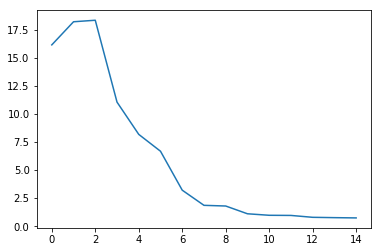

In [61]:
plt.plot(sorted(times, key=lambda x:abs(x - np.mean(times)))[:-outnum])

In [39]:
np.mean(times)

16.008206248283386

In [23]:
res_list = res_dict_all['obj_1_obs3']['ToolReach']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

00: [2.023041009902954, 5, 3, 3, 0, 82, 16, 8, True]
01: [3.90523099899292, 5, 6, 5, 0, 35, 8, 2, True]
02: [0.7565329074859619, 5, 3, 3, 0, 23, 4, 0, True]
03: [1.9314930438995361, 5, 3, 3, 0, 53, 11, 6, True]
04: [1.3326780796051025, 5, 3, 3, 0, 52, 9, 4, True]
05: [1.388132095336914, 5, 3, 3, 0, 165, 10, 1, True]
06: [2.795285940170288, 5, 5, 5, 2, 211, 29, 4, True]
07: [93.6167540550232, 9, 10, 10, 1, 1088, 111, 79, True]
08: [4.766283988952637, 5, 3, 3, 0, 25, 7, 2, True]
09: [2.079124927520752, 5, 3, 3, 0, 34, 6, 1, True]
10: [0.753741979598999, 5, 3, 3, 0, 7, 3, 1, True]
11: [5.915006875991821, 5, 5, 5, 1, 23, 6, 1, True]
12: [1.1763639450073242, 5, 3, 3, 0, 23, 4, 0, True]
13: [1.309079885482788, 5, 3, 3, 0, 10, 3, 0, True]
14: [3.1741631031036377, 5, 3, 3, 0, 424, 25, 11, True]


In [21]:
res_list = res_dict_all['obj_1_obs3']['Full']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

00: [0.7895381450653076, 5, 3, 3, 0, 11, 2, 0, True]
01: [1.7976248264312744, 5, 3, 3, 0, 31, 6, 3, True]
02: [1.8583440780639648, 5, 3, 3, 0, 71, 7, 1, True]
03: [98.68280410766602, 9, 23, 22, 15, 1308, 158, 90, True]
04: [8.187709093093872, 5, 5, 5, 1, 81, 11, 2, True]
05: [0.9705190658569336, 5, 3, 3, 0, 13, 5, 1, True]
06: [6.684529066085815, 5, 4, 4, 1, 72, 11, 2, True]
07: [102.48754906654358, 0, 0, 0, 0, 330, 22, 16, False]
08: [3.2100989818573, 5, 3, 3, 0, 289, 26, 15, True]
09: [0.7596890926361084, 5, 3, 3, 0, 14, 4, 1, True]
10: [0.6657211780548096, 5, 3, 3, 0, 3, 2, 0, True]
11: [0.9573731422424316, 5, 3, 3, 0, 14, 4, 0, True]


In [100]:
res_list = res_dict_all['obj_3_hard']['Tool']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

00: [7.613916873931885, 5, 3, 3, 0, 54, 44, 28, True]
01: [100.0527720451355, 0, 9, 9, 1, 813, 588, 393, False]
02: [23.67825198173523, 5, 3, 3, 0, 174, 104, 76, True]
03: [63.73325705528259, 9, 6, 6, 1, 30, 20, 17, True]
04: [7.5678510665893555, 5, 3, 3, 0, 37, 18, 15, True]
05: [100.01080012321472, 0, 0, 0, 0, 732, 422, 349, False]
06: [100.1502468585968, 0, 0, 0, 0, 782, 454, 379, False]
07: [27.42594814300537, 13, 9, 9, 1, 112, 72, 53, True]
08: [100.01944208145142, 0, 0, 0, 0, 764, 499, 397, False]
09: [100.10912203788757, 0, 0, 0, 0, 721, 476, 410, False]
10: [100.22824192047119, 0, 0, 0, 0, 663, 509, 293, False]
11: [0.8340280055999756, 5, 3, 3, 0, 7, 4, 0, True]
12: [100.01716685295105, 0, 0, 0, 0, 852, 485, 380, False]
13: [100.14102101325989, 0, 0, 0, 0, 764, 595, 412, False]
14: [15.339173078536987, 5, 3, 3, 0, 81, 54, 47, True]
15: [20.501925945281982, 13, 7, 7, 0, 167, 99, 47, True]
16: [2.2544162273406982, 5, 3, 3, 0, 5, 2, 0, True]
17: [3.8417670726776123, 5, 3, 3, 0, 17

In [101]:
res_list = res_dict_all['obj_3_hard']['ToolReach']
for i, res in enumerate(res_list):
    print("{:02}: {}".format(i, res))

00: [1.2833878993988037, 5, 3, 3, 0, 14, 6, 4, True]
01: [1.1672658920288086, 5, 3, 3, 0, 36, 11, 9, True]
02: [6.359817028045654, 5, 3, 3, 0, 429, 108, 34, True]
03: [1.471876859664917, 5, 3, 3, 0, 20, 7, 4, True]
04: [17.056393146514893, 5, 4, 4, 1, 534, 118, 46, True]
05: [1.396705150604248, 5, 3, 3, 0, 32, 5, 2, True]
06: [47.93317008018494, 9, 31, 31, 4, 667, 184, 96, True]
07: [20.234771966934204, 9, 6, 6, 1, 625, 127, 42, True]
08: [100.00004982948303, 0, 0, 0, 0, 100, 23, 3, False]
09: [12.52300500869751, 9, 5, 5, 0, 172, 53, 32, True]
10: [100.00339913368225, 0, 0, 0, 0, 1202, 554, 186, False]
11: [1.366257905960083, 5, 3, 3, 0, 21, 4, 1, True]
12: [100.00004887580872, 0, 1, 1, 1, 197, 51, 26, False]
13: [71.92308211326599, 9, 5, 5, 0, 4258, 1770, 628, True]
14: [1.6730141639709473, 5, 3, 3, 0, 105, 13, 10, True]
15: [100.000079870224, 0, 3, 3, 3, 535, 209, 51, False]
16: [1.1324870586395264, 5, 3, 3, 0, 16, 6, 4, True]
17: [1.8022148609161377, 5, 3, 3, 0, 12, 4, 0, True]
18: 

In [81]:
np.where([res[0] < 99 and not res[-1] for res in res_dict_all['obj_3_None']['Full']])

(array([], dtype=int64),)

#### checking error scenes

In [16]:
from pkg.planning.motion.interface import MOTION_PATH
from pkg.planning.filtering.latticized_filter import SCENE_PATH

print("==== MOTION scene errors ====")
print(sorted([fname for fname in os.listdir(MOTION_PATH)]))
print("==== Lcheck scene errors ====")
print(sorted([fname for fname in os.listdir(SCENE_PATH) if "OK" not in fname]))

==== MOTION scene errors ====
[]
==== Lcheck scene errors ====
[]


## No Step3 before IK
```
==================================================
RES_ROOT: stowing-deep-result-before-ik-only2
DAT_DIR: 20210906-125756
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
==================================================
obj_1
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_1      ================================================== valid=20
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    11.14      5.8     3.65     3.65(100.0)      0.1( 1.39)    32.15    32.15(100.0)    25.35(72.67)      0.0       20
Tool      :     1.53      5.0      3.0      3.0(100.0)      0.0(  0.0)     27.2      6.3(45.08)     2.35(32.21)      0.0       20
ToolReach :     1.59      5.2      3.6      3.5(98.17)     0.15( 2.92)    40.05      5.9(27.01)     0.95(12.56)      0.0       20
Full      :     1.86      5.0      3.7      3.6(98.17)     0.25( 5.33)     31.0      5.6(33.29)      0.9(12.58)      0.0       20
obj_3
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3      ================================================== valid=18
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    17.06     5.89     3.56     3.56(100.0)     0.11( 2.31)    81.78    81.78(100.0)    67.44(73.81)     10.0       20
Tool      :     3.67     5.22      3.5      3.5(100.0)     0.39( 4.63)    55.72    10.39(32.71)     2.72(28.16)     10.0       20
ToolReach :     1.78      5.0     3.06     3.06(100.0)     0.06( 1.39)    111.5    11.44( 22.3)     1.94(17.26)      5.0       20
Full      :     1.52      5.0     3.22     3.17(98.89)     0.06( 1.11)    95.11    11.61( 21.0)     2.17(17.21)      5.0       20
obj_3_pole
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3_pole ================================================== valid=12
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    25.51     5.86     4.29     4.29(100.0)      0.5( 7.22)   105.36   105.36(100.0)    87.07( 71.4)     30.0       20
Tool      :     6.37      5.5     3.83     3.83(100.0)     0.42( 6.88)    138.0    18.75(21.21)    11.58(55.84)     15.0       20
ToolReach :    14.07     5.67     5.58     5.58(100.0)     0.67( 4.95)   726.08    69.08(15.65)    39.17(41.31)     35.0       20
Full      :    16.88      6.0     7.58      6.5(93.98)      1.0( 9.38)   603.75     48.0(15.33)    23.58(38.36)     25.0       20
obj_3_hard
None files: 20
Tool files: 20
ToolReach files: 20
Full files: 20
================================================== obj_3_hard ================================================== valid=10
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    23.25      6.0     4.75     4.75(100.0)     0.67( 7.87)     99.5     99.5(100.0)    75.75(77.61)     40.0       20
Tool      :    15.52      6.2      3.9      3.9(100.0)      0.2( 2.78)     57.6     34.3(56.47)     25.3( 60.6)     40.0       20
ToolReach :     5.36      5.4      3.4      3.4(100.0)      0.2( 4.17)    178.8     39.8(28.94)     14.8(45.59)     25.0       20
Full      :      8.7      5.4      4.4      4.0( 95.5)      0.1( 1.25)    336.6     71.7(24.08)     35.9(38.64)     25.0       20
```

## Full before IK
```
==================================================
RES_ROOT: stowing-deep-result
DAT_DIR: 20210906-125756
CNAME_LIST: ['None', 'Tool', 'ToolReach', 'Full']
==================================================
obj_1
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_1      ================================================== valid=10
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     3.83      5.4      3.3      3.3(100.0)      0.1(  2.5)     12.7     12.7(100.0)      9.3(68.09)      0.0       10
Tool      :     3.28      5.4      3.6      3.5( 98.0)      0.1( 1.43)     29.5      9.8(54.47)      5.7(39.76)      0.0       10
ToolReach :     1.12      5.0      3.0      3.0(100.0)      0.0(  0.0)     21.2      4.8(38.15)      1.2(18.62)      0.0       10
Full      :     2.66      5.0      3.3      3.2( 98.0)      0.1(  2.5)     67.5      6.0(24.73)      1.1(14.31)      0.0       10
obj_3
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_3      ================================================== valid=9
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :     8.36     5.44     3.33     3.33(100.0)     0.11( 2.78)    35.56    35.56(100.0)    27.78(75.88)     10.0       10
Tool      :     2.71      5.0     3.22     3.22(100.0)     0.11( 2.22)     81.0    14.67(35.09)     4.56( 18.7)     10.0       10
ToolReach :     4.23     5.67     3.67     3.67(100.0)     0.33( 6.48)   201.56    30.89(32.25)      5.0(17.26)     10.0       10
Full      :     3.98      5.0     3.56     3.44(98.15)     0.11( 2.22)   158.89    18.11( 19.0)      2.0(11.21)     10.0       10
obj_3_pole
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_3_pole ================================================== valid=8
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    27.07      8.0     6.12     6.12(100.0)      0.5( 6.58)   117.75   117.75(100.0)    92.62(79.86)     20.0       10
Tool      :    15.43      6.5     7.62      7.5(99.22)      1.0( 8.52)   513.12    59.88( 20.3)    38.62(51.82)     20.0       10
ToolReach :    11.07      5.0     5.62      5.5(97.92)      1.0( 8.33)    274.0     31.0( 19.2)     20.0(52.52)     10.0       10
Full      :    13.51      5.5     6.88     6.75(99.04)     0.88( 4.17)   367.38     24.5(20.91)     7.38(21.67)     20.0       10
obj_3_hard
None files: 10
Tool files: 10
ToolReach files: 10
Full files: 10
================================================== obj_3_hard ================================================== valid=3
Checker   :     Time  Actions   MP_tot       MP trials        MP fails   IK_tot       IK trials        IK fails  Fail(%)    Total
None      :    34.78      6.0     6.88     6.88(100.0)     0.75(  6.3)   148.88   148.88(100.0)    126.5( 76.6)     20.0       10
Tool      :      9.2      5.0      3.0      3.0(100.0)      0.0(  0.0)    40.67    30.67(70.14)    26.33(79.12)     50.0       10
ToolReach :     1.95      5.0      3.0      3.0(100.0)      0.0(  0.0)     22.0      7.0(33.82)     4.67(66.87)     30.0       10
Full      :    34.88      5.0     8.67     8.67(100.0)     1.33(12.22)    236.0     35.0( 21.0)     8.67(27.09)     40.0       10
```

### Indy Result bak: no step 3 before IK, angle, pole distance added, place sample limit, no appraoch
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     valid=48
None      : 12.28      5.52       3.46       3.43       0.11       33.96      33.96      27.07      4          50        
Tool      : 5.35       5.08       3.21       3.17       0.04       48.73      10.23      5.25       1          50        
ToolReach : 5.7        5.08       3.54       3.52       0.23       37.12      6.67       1.58       1          50        
Full      : 4.61       5.0        3.67       3.44       0.06       24.98      6.25       1.81       2          50        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     valid=47
None      : 26.37      6.19       4.02       4.02       0.09       101.7      101.7      87.87      3          50        
Tool      : 9.7        5.68       4.17       4.04       0.06       256.21     42.11      20.74      2          50        
ToolReach : 5.36       5.09       3.3        3.23       0.04       227.15     22.28      5.51       2          50        
Full      : 6.15       5.17       3.64       3.47       0.06       181.26     20.87      6.55       0          50        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     valid=42
None      : 32.37      5.65       3.97       3.92       0.3        113.19     113.19     102.27     13         50        
Tool      : 15.37      5.19       3.88       3.83       0.48       442.57     55.02      36.81      5          50        
ToolReach : 12.89      5.52       5.62       5.45       0.64       452.29     51.55      29.36      4          50        
Full      : 11.04      5.0        5.62       4.95       0.4        309.21     32.4       19.4       4          50              
```

### Indy Result bak: No step 3 before IK, angle, pole distance added
```
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 24.31      6.56       3.78       3.78       0.0        55.67      55.67      50.72      22         40        
Tool      : 24.46      6.52       3.86       3.86       0.05       188.05     55.81      37.0       10         39        
ToolReach : 19.37      5.19       3.24       3.24       0.05       360.81     47.0       28.0       11         39        
Full      : 15.9       5.9        3.62       3.62       0.1        274.71     25.1       14.81      12         39        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 36.2       7.0        4.0        4.0        0.0        289.08     83.83      56.08      10         30        
ToolReach : 27.5       5.0        3.0        3.0        0.0        522.75     73.42      44.17      11         30        
Full      : 19.3       5.92       3.5        3.5        0.08       385.33     32.17      20.08      12         30   
```

### Indy Result bak: No step 3 before IK
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 13.82      6.75       4.04       3.94       0.0        39.35      39.35      31.31      2          50        
Tool      : 9.25       6.17       3.71       3.65       0.02       41.06      16.5       9.04       1          50        
ToolReach : 3.78       5.92       3.46       3.46       0.0        35.44      9.46       2.21       0          50        
Full      : 4.09       5.5        4.1        3.98       0.17       36.56      7.67       1.92       1          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 11.72      6.12       3.75       3.66       0.03       52.69      20.41      11.62      1          34        
ToolReach : 4.33       6.38       3.69       3.69       0.0        45.22      12.28      3.03       0          34        
Full      : 4.41       5.38       4.47       4.28       0.25       34.5       8.22       2.0        1          34        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 23.15      7.64       4.82       4.7        0.09       67.16      67.16      54.48      6          50        
Tool      : 14.9       6.55       3.95       3.91       0.02       162.43     34.95      16.36      6          50        
ToolReach : 7.15       6.14       3.8        3.8        0.16       89.45      14.34      4.2        2          50        
Full      : 10.41      5.89       5.86       5.05       0.02       211.61     30.91      9.91       4          50        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 21.16      7.15       4.38       4.31       0.04       219.08     50.0       24.15      6          32        
ToolReach : 9.4        6.77       4.27       4.27       0.27       107.96     19.5       5.19       2          32        
Full      : 14.94      6.5        7.85       6.46       0.04       312.77     47.27      15.12      4          32        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 42.18      7.44       4.71       4.68       0.06       121.74     121.74     108.65     16         50        
Tool      : 15.32      6.0        4.34       4.34       0.47       182.56     22.31      12.47      9          50        
ToolReach : 20.23      6.62       4.56       4.56       0.25       458.78     45.44      18.47      5          50        
Full      : 12.32      5.75       4.06       4.03       0.22       416.84     32.78      15.0       10         50        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 16.81      6.09       4.5        4.5        0.59       180.68     24.32      14.05      9          40        
ToolReach : 25.86      6.82       4.91       4.91       0.32       604.05     60.5       24.91      5          40        
Full      : 13.2       5.91       4.36       4.32       0.27       391.82     34.91      14.91      10         40    
```

### Indy Result bak: full filter before IK (MP_tot wrong)
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 12.63      7.29       4.33       4.33       0.04       45.12      45.12      34.71      2          50        
Tool      : 9.59       6.36       3.83       3.83       0.06       52.09      21.55      12.0       1          50        
ToolReach : 7.72       5.26       3.19       3.19       0.02       23.74      4.6        0.81       0          50        
Full      : 7.96       6.02       3.53       3.53       0.0        36.02      7.55       1.89       3          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 14.3       7.0        4.27       4.27       0.12       79.77      32.77      18.77      1          29        
ToolReach : 11.86      5.46       3.35       3.35       0.04       24.73      4.96       1.0        0          29        
Full      : 11.15      5.92       3.46       3.46       0.0        48.15      9.15       2.65       3          29        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 19.07      7.05       4.03       4.03       0.0        54.23      54.23      42.62      11         50        
Tool      : 13.64      6.73       4.03       4.03       0.03       162.86     30.41      13.84      8          50        
ToolReach : 6.59       6.05       3.57       3.57       0.05       88.7       12.57      3.73       4          50        
Full      : 11.39      6.73       3.97       3.97       0.03       86.38      15.22      4.03       6          49        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 24.54      7.86       4.5        4.5        0.0        362.07     60.86      28.93      8          26        
ToolReach : 10.86      6.71       3.86       3.86       0.0        183.21     23.21      7.29       4          26        
Full      : 16.57      7.0        4.07       4.07       0.0        154.36     23.29      5.79       6          26        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 36.2       7.91       5.59       5.59       0.21       99.12      99.12      86.56      16         50        
Tool      : 16.99      6.03       4.05       4.05       0.21       292.29     35.89      21.45      9          50        
ToolReach : 16.52      6.05       3.76       3.76       0.08       512.53     39.05      19.95      5          50        
Full      : 18.31      6.79       4.0        4.0        0.03       188.82     28.53      8.32       7          50        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 19.04      6.22       4.22       4.22       0.17       275.74     40.87      25.39      9          35        
ToolReach : 22.48      6.22       3.65       3.65       0.04       705.13     50.52      27.7       5          35        
Full      : 23.77      7.26       4.3        4.3        0.04       259.78     39.09      11.3       7          35     
```

### Panda Result bak: full filter before IK (MP_tot wrong)
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 14.65      6.7        3.94       3.94       0.04       54.79      54.79      40.77      3          50        
Tool      : 10.45      6.77       4.32       4.32       0.11       56.4       21.47      11.34      1          50        
ToolReach : 7.82       5.85       4.23       4.23       0.15       77.91      16.68      4.96       1          50        
Full      : 8.01       6.53       3.94       3.94       0.06       71.89      20.91      6.6        1          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 13.59      7.58       4.81       4.81       0.1        70.32      27.48      14.35      1          34        
ToolReach : 10.23      5.9        4.48       4.48       0.16       97.19      21.39      6.68       1          34        
Full      : 10.42      6.81       4.16       4.16       0.1        94.29      28.13      8.97       1          34        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 23.29      7.25       5.0        5.0        0.16       81.18      81.18      69.98      6          50        
Tool      : 12.71      6.4        4.09       4.09       0.09       138.07     29.67      15.65      5          50        
ToolReach : 6.86       6.47       3.86       3.86       0.07       200.07     25.26      10.81      3          50        
Full      : 10.31      6.4        4.12       4.12       0.09       131.4      20.47      6.93       4          50        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 22.92      6.78       4.67       4.67       0.17       251.28     51.89      28.72      5          25        
ToolReach : 10.08      6.33       3.67       3.67       0.0        343.33     38.39      17.56      3          25        
Full      : 17.25      6.78       4.89       4.89       0.22       195.0      30.72      10.61      4          25        
============================== obj_3_pole ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 31.73      5.0        3.0        3.0        0.0        221.0      221.0      216.0      10         13        
Tool      : 16.91      9.0        5.0        5.0        0.0        358.0      65.0       38.0       8          13        
ToolReach : 6.26       9.0        5.0        5.0        0.0        262.0      34.0       17.0       4          13        
Full      : 17.74      5.0        3.0        3.0        0.0        2377.0     30.0       11.0       5          12        
============================== obj_3_pole-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 16.91      9.0        5.0        5.0        0.0        358.0      65.0       38.0       8          12        
ToolReach : 6.26       9.0        5.0        5.0        0.0        262.0      34.0       17.0       4          12        
Full      : 17.74      5.0        3.0        3.0        0.0        2377.0     30.0       11.0       5          12       
```

### Panda Result bak: full filter before IK, sampling 5
```
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 19.32      7.05       4.93       4.93       0.21       76.79      76.79      65.3       5          48        
Tool      : 6.93       5.64       3.32       3.32       0.0        218.5      33.55      15.27      1          48        
ToolReach : 5.65       5.27       3.25       3.23       0.05       260.36     33.41      13.8       3          48        
Full      : 10.26      6.0        4.16       4.16       0.14       350.45     39.45      15.89      1          48        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 11.0       6.4        3.7        3.7        0.0        395.9      62.3       28.45      1          24        
ToolReach : 8.23       5.4        3.2        3.2        0.0        452.05     60.65      24.4       3          24        
Full      : 17.96      6.6        5.25       5.25       0.3        682.35     75.0       31.7       1          24    
```

### Panda Result bak: no step 3 before IK, sampling 10
```
============================== obj_1      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 15.21      6.17       4.02       4.02       0.19       61.51      61.51      49.28      3          50        
Tool      : 4.23       5.08       3.06       3.06       0.02       61.7       9.32       4.84       0          50        
ToolReach : 2.86       5.08       3.2        3.2        0.1        54.64      7.02       2.24       0          50        
Full      : 3.84       5.24       3.42       3.42       0.16       38.4       6.48       2.08       0          50        
============================== obj_1-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 5.18       5.12       3.09       3.09       0.03       82.81      11.09      5.97       0          32        
ToolReach : 3.32       5.12       3.31       3.31       0.16       72.66      8.38       2.91       0          32        
Full      : 4.76       5.38       3.66       3.66       0.25       41.75      7.38       2.59       0          32        
============================== obj_3      ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
None      : 16.45      6.6        3.8        3.8        0.0        89.3       89.3       76.6       2          22        
Tool      : 10.51      6.2        5.3        5.3        0.55       240.0      48.9       21.45      1          22        
ToolReach : 3.37       5.0        3.15       3.15       0.05       118.0      12.4       6.15       1          22        
Full      : 3.81       5.2        3.25       3.25       0.1        118.35     12.1       5.05       2          22        
============================== obj_3-hard ==============================
Checker   : Time       Actions    MP_tot     MPs        MP fails   IK_tot     IKs        IK fails   Failures   Total     
Tool      : 21.12      7.86       9.0        9.0        1.43       517.86     108.43     45.14      1          9         
ToolReach : 4.03       5.0        3.43       3.43       0.14       169.0      16.71      10.14      1          9         
Full      : 5.27       5.57       3.71       3.71       0.29       162.57     18.71      6.86       2          9        
```

## Res - panda
```

```

## Res - indy7
```
============================== obj_1           ==============================
Checker        : Planning time   Motion count    MP trials       Failed MP       Failures        Total          
None           : 7.2             5.8             3.4             0.0             0               10             
Tool           : 7.83            6.5             4.5             0.3             0               10             
ToolReach      : 3.55            5.8             4.2             0.3             0               10             
Full           : 1.94            5.4             3.2             0.0             0               10             
 
============================== obj_3           ==============================
Checker        : Planning time   Motion count    MP trials       Failed MP       Failures        Total          
None           : 23.27           8.11            4.56            0.0             1               10             
Tool           : 11.77           5.5             6.12            0.12            2               10             
ToolReach      : 5.02            5.57            9.0             0.0             3               10             
Full           : 6.66            5.44            3.56            0.0             1               10             
 
============================== obj_3_pole      ==============================
Checker        : Planning time   Motion count    MP trials       Failed MP       Failures        Total          
None           : 48.29           9.0             5.0             0.0             4               10             
Tool           : 15.81           6.0             11.75           1.12            2               10             
ToolReach      : 31.28           7.0             14.67           1.17            4               10             
Full           : 15.32           5.0             5.0             0.0             5               10            
```

## Res - indy7 - new
```
============================== obj_1      ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
None      : 11.62      6.53       3.87       0.04       38.17      30.3       3          50        
Tool      : 7.75       5.9        4.75       0.33       24.0       12.96      2          50        
ToolReach : 3.13       5.17       3.19       0.06       6.12       1.67       0          50        
Full      : 2.29       5.58       3.54       0.1        8.1        2.06       0          50        
============================== obj_1-hard ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
Tool      : 14.99      6.05       6.68       0.74       45.53      24.42      0          19        
ToolReach : 5.81       5.42       3.47       0.16       6.84       1.63       0          19        
Full      : 3.41       6.05       4.0        0.21       11.05      2.16       0          19        
============================== obj_3      ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
None      : 19.86      7.19       4.34       0.08       61.74      50.17      8          61        
Tool      : 10.1       6.84       4.2        0.1        30.48      16.24      8          61        
ToolReach : 5.66       6.2        3.78       0.08       25.04      7.42       5          61        
Full      : 6.07       6.08       4.02       0.1        22.0       6.5        6          61        
============================== obj_3-hard ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
Tool      : 26.22      9.0        6.0        0.17       83.83      50.33      0          6         
ToolReach : 15.82      7.0        4.0        0.0        65.33      18.17      0          6         
Full      : 13.71      6.33       6.0        0.17       59.83      17.67      0          6         
============================== obj_3_pole ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
None      : 32.5       7.15       5.55       0.61       114.12     100.67     17         50        
Tool      : 19.07      5.84       5.19       0.51       44.76      25.49      10         50        
ToolReach : 14.79      5.97       5.97       0.65       51.27      20.22      5          50        
Full      : 10.58      6.03       6.81       0.76       38.32      17.24      8          50        
============================== obj_3_pole-hard ==============================
Checker   : Plan time  Actions    MPs        MP fails   IKs        IK fails   Failures   Total     
Tool      : 34.47      7.4        4.2        0.0        61.6       29.2       0          5         
ToolReach : 47.08      6.6        3.8        0.0        199.4      74.8       0          5         
Full      : 22.43      7.2        12.2       1.8        83.2       37.2       0          5        
```

In [ ]:
from __future__ import print_function
import os
RNB_PLANNING_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(RNB_PLANNING_DIR, 'src'))
from pkg.controller.combined_robot import *
from pkg.utils.utils import get_now, try_mkdir
import subprocess

DATA_PATH = os.path.join(RNB_PLANNING_DIR, "data")
try_mkdir(DATA_PATH)

DAT_ROOT = "stowing-deep"
RES_ROOT = "stowing-deep-result"

TEST_DATA_PATH = os.path.join(DATA_PATH, DAT_ROOT)
try_mkdir(TEST_DATA_PATH)

TEST_RESULT_PATH = os.path.join(DATA_PATH, RES_ROOT)
try_mkdir(TEST_RESULT_PATH)


HEADS = ["plan_time", "length", "MP_count", "failed_MPs", "success"]

In [ ]:
RTYPE = "indy7"
DAT_DIR = '20210613-035257'
FILE_OPTION = "obj_3_pole"
# DAT_DIR, FILE_OPTION = "20210613-023004", "obj_1"
# DAT_DIR, FILE_OPTION = "20210612-114040", "obj_1"
# DAT_DIR, FILE_OPTION = "20210612-151342", "obj_3"
# DAT_DIR, FILE_OPTION = "20210612-161536", "obj_3_pole"

# RTYPE = "panda"
# DAT_DIR = '20210613-035119'
# FILE_OPTION = "obj_1"
# # DAT_DIR, FILE_OPTION = "20210613-022832", "obj_1"
# # # DAT_DIR, FILE_OPTION = "20210612-221934", "obj_1"

CNAME_LIST = ['None','Tool','ToolReach','Full'] #,'Pairwise']
GRASP_SAMPLE = 10
VISUALIZE = False
PLAY_RESULT = False
TIMEOUT_MOTION = 5
MAX_TIME = 100
SHOW_STATE = False


### test

In [ ]:
ROBOT_DATA_ROOT = os.path.join(TEST_DATA_PATH, RTYPE)
ROBOT_RESULT_ROOT = os.path.join(TEST_RESULT_PATH, RTYPE)
DATASET_PATH = os.path.join(ROBOT_DATA_ROOT, DAT_DIR)
RESULTSET_PATH = os.path.join(ROBOT_RESULT_ROOT, DAT_DIR)
file_list = sorted(os.listdir(DATASET_PATH))

### load results

In [ ]:
res_dict_all = defaultdict(lambda: defaultdict(list))
resfile_list = sorted(os.listdir(os.path.join(RESULTSET_PATH)))
for resfile in resfile_list:
    args = resfile[:-4].split("_")[1:]
    f_option = "_".join(args[:-2])
    fid, cname = args[-2:]
    resdat = load_pickle(os.path.join(RESULTSET_PATH, resfile))
    assert len(res_dict_all[f_option][cname]) == int(fid)
    res_dict_all[f_option][cname].append([resdat[head] for head in HEADS])

In [ ]:
exp_list = ['obj_1', 'obj_3', 'obj_3_pole']
for ekey in exp_list:
    if ekey not in res_dict_all:
        continue
    res_dict = res_dict_all[ekey]
    print("="*30 + " {:<15} ".format(ekey) + "="*30)
    print("{:<15}: {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format("Checker", "Planning time", "Motion count", "MP trials", "Failed MP", "Failures", "Total"))
    for cname in CNAME_LIST:
        if cname in res_dict:
            vv = np.array(res_dict[cname])[:10,:]
            if len(vv)>0:
                succ_vec = vv[:,-1]
                fail_vec = np.logical_not(succ_vec)
                idc_succ = np.where(succ_vec)[0]
                print(
                    "{:<15}: {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".format(cname,
                                    *(list(np.round(np.mean(vv[idc_succ, :-1], axis=0), 2)) \
                                      +[np.sum(fail_vec), len(vv)])))
    print(" ")